In [2]:
from general_tools.notebook.gpu_utils import setup_one_gpu
GPU = 0
setup_one_gpu(GPU)

Picking GPU 0


In [135]:
import sys
import numpy as np
import os.path as osp
import tensorflow as tf
import glob


import tf_lab.point_clouds.in_out as pio
from tf_lab.point_clouds.in_out import PointCloudDataSet, write_model_ids_of_datasets
from tf_lab.point_clouds.point_net_ae import PointNetAutoEncoder
from tf_lab.point_clouds.autoencoder import Configuration as Conf



from tf_lab.autopredictors.scripts.helper import shape_net_category_to_synth_id, match_incomplete_to_complete_data



from tf_lab.autopredictors.scripts.virt_scan_data import plotting_default_params


from general_tools.notebook.tf import reset_tf_graph                                                  
from general_tools.in_out.basics import create_dir, delete_files_in_directory, files_in_subdirs
from general_tools.simpletons import select_first_last_and_k
from geo_tool import Point_Cloud

from tf_lab.nips.shape_net import pc_loader as sn_pc_loader
# from tf_lab.nips.eric_semantic_parts 

from tf_lab.autopredictors.exploration import latent_embedding_of_entire_dataset

from tf_lab.autopredictors.evaluate import eval_model, read_saved_epochs

In [5]:
top_eric_dir = '/orions4-zfs/projects/lins2/Panos_Space/DATA/Point_Clouds/Shape_Net/With_Part_Annotation_Eric_Version/'
top_out_dir = '/orions4-zfs/projects/lins2/Panos_Space/DATA/Point_Clouds/Shape_Net/With_Part_Annotation_Panos_Version/'
syn_id = '03001627'
segs_top_dir = osp.join(top_eric_dir, syn_id, 'expert_verified', 'points_label')

In [27]:
erics_seg_extension = '.seg'
model_id_to_part_types = dict()
for file_name in glob.glob(osp.join(segs_top_dir, '*' + erics_seg_extension)):
    gt_seg = np.loadtxt(file_name, dtype=np.int)
    model_name = file_name.split('/')[-1][:-len(erics_seg_extension)]
    part_types = set(gt_seg) - set([0]) # Zero is not a real segment: remove it.
    model_id_to_part_types[model_name] = part_types

In [72]:
target_parts = [1,2,3]

res = set()
for model in model_id_to_part_types:
    if model_id_to_part_types[model] == set(target_parts):
        res.add(model)        

In [74]:
# cat1 = res
# cat2 = res

#     d = {'030001627': {'back': 4, 'seat': 2, 'arm': 3, 'leg': 1}}


937 2754


In [49]:
# experiment_name = '1_three_fc_dec_spn_2048pts_chamfer'
experiment_name = '1_three_fc_dec_with_spn_2048pts_chamfer'
top_data_dir = '/orions4-zfs/projects/lins2/Panos_Space/DATA/'
train_dir = osp.join(top_data_dir, 'OUT/models/nips/vanilla_ae/')
train_dir = osp.join(train_dir, experiment_name)
conf = Conf.load(osp.join(train_dir, 'configuration'))
conf.n_output = conf.n_input
reset_tf_graph()
ae = PointNetAutoEncoder(experiment_name, conf)
saved_epochs = read_saved_epochs(conf.train_dir)
last_epoch = saved_epochs[-1]
ae.restore_model(conf.train_dir, last_epoch, verbose=True)

Model restored in epoch 1000.


In [52]:
n_pc_samples = 2048
top_data_dir = '/orions4-zfs/projects/lins2/Panos_Space/DATA/'


full_pclouds_path = osp.join(top_data_dir, 'Point_Clouds/Shape_Net/Core/from_manifold_meshes/centered/', str(n_pc_samples))
full_pclouds_path = osp.join(full_pclouds_path, syn_id)

full_file_names = pio.load_filenames_of_input_data(full_pclouds_path, '.ply')
full_pclouds, full_model_ids, full_syn_ids = pio.load_crude_point_clouds(file_names=full_file_names,\
                                                                           n_threads=50, loader=sn_pc_loader)
print '%d files containing complete point clouds were found.' % (len(full_pclouds), )
model_unames = full_model_ids + '.' + full_syn_ids

6778 files containing complete point clouds were found.


In [80]:
_, latent_codes, _ = latent_embedding_of_entire_dataset(PointCloudDataSet(full_pclouds, labels=full_model_ids, init_shuffle=False), ae, conf)

In [89]:
cat1_index = match_incomplete_to_complete_data(full_model_ids, cat1)

cat1_mv = np.mean(latent_codes[cat1_index,:], axis=0)

cat2_index = match_incomplete_to_complete_data(full_model_ids, cat2)
cat2_mv = np.mean(latent_codes[cat2_index,:], axis=0)


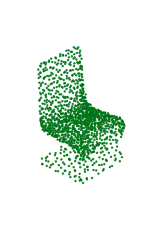

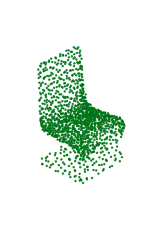

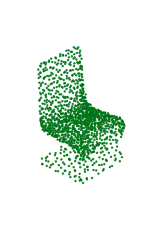

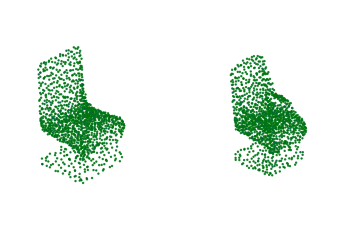

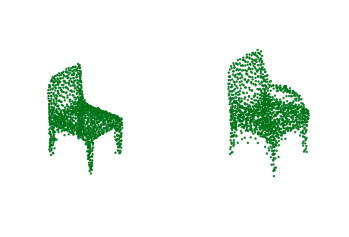

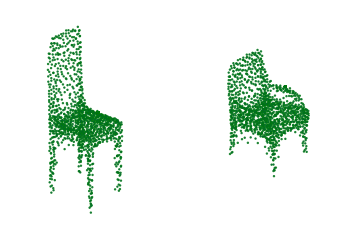

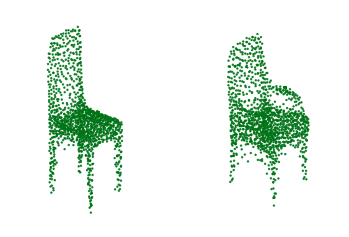

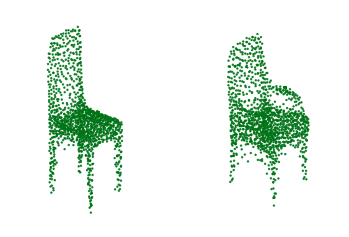

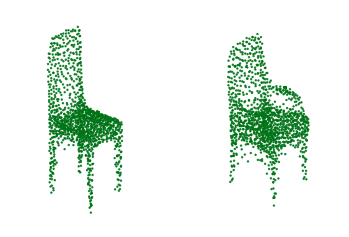

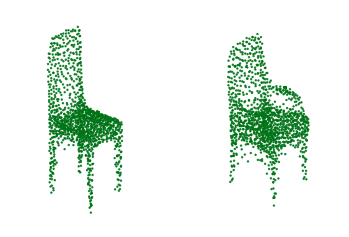

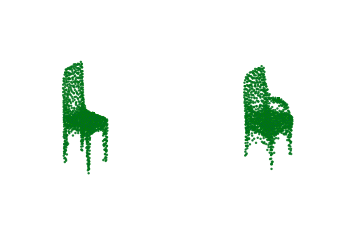

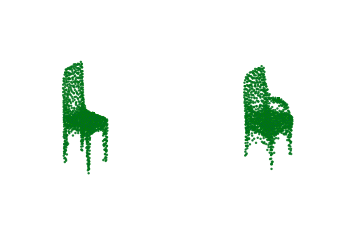

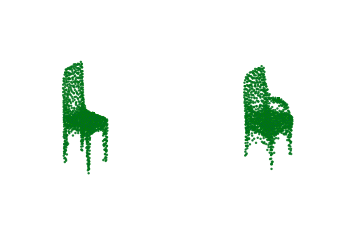

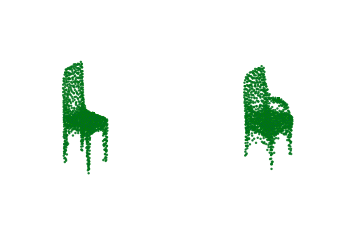

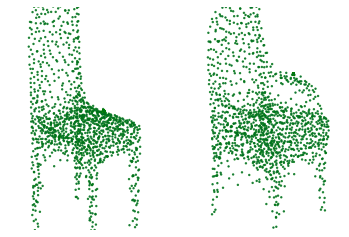

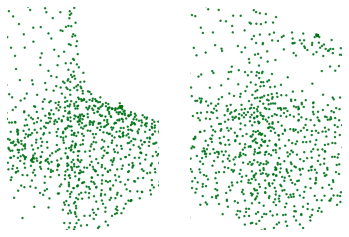

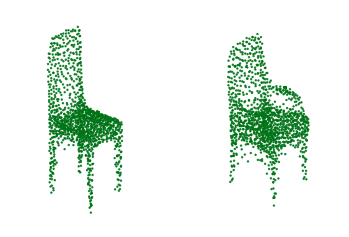

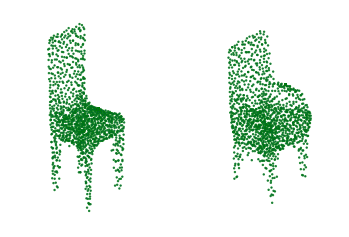

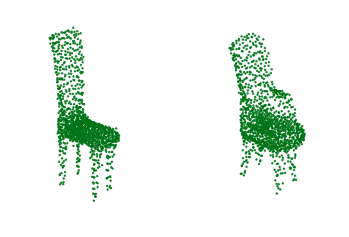

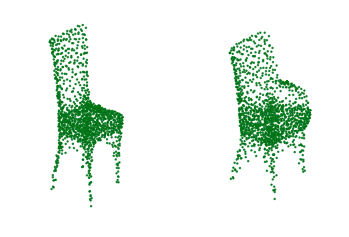

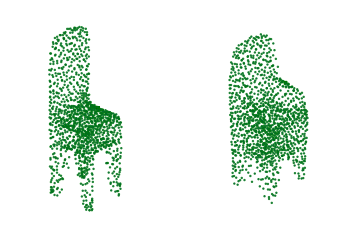

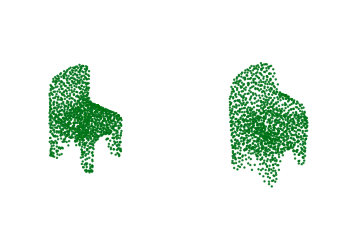

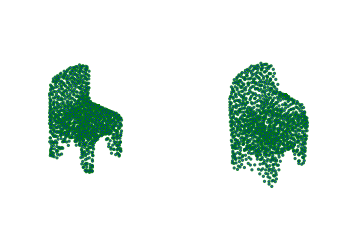

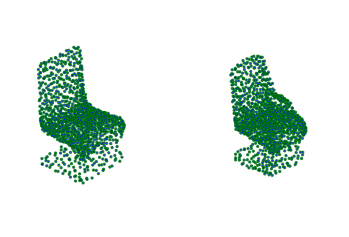

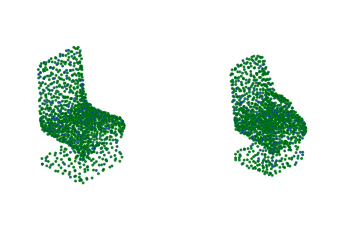

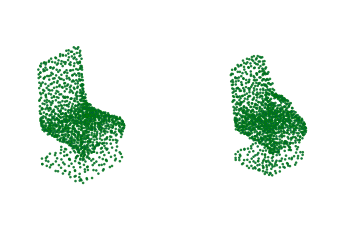

KeyboardInterrupt: 

In [ ]:
Point_Cloud(ae.decode(cat2_mv)[0]).plot()

i = 1
plotconf = plotting_default_params('chair')
plotconf['elev'] = 20
plotconf['show_axis'] = False
plotconf['show'] = False
plotconf['in_u_sphere'] = False
plotconf['s'] = 20
plotconf['color'] = 'blue'

fig = plt.figure()
ax = plt.subplot(1, 2, 1, projection='3d')
pc = Point_Cloud(ae.decode(latent_codes[cat2_index[i]])[0])
print np.max(pc.points), np.min(pc.points)
pc.plot(axis=ax, **plotconf)

# a = -0.5
# b = 0.5
# ax.set_xlim3d(a,b)
# ax.set_ylim3d(a,b)
# ax.set_zlim3d(a,b)

ax = plt.subplot(1, 2, 2, projection='3d')
pc = Point_Cloud(ae.decode(latent_codes[cat2_index[i]] + (cat1_mv - cat2_mv) )[0])
pc.plot(axis=ax, **plotconf);
print np.max(pc.points), np.min(pc.points)

# ax.set_xlim3d(a,b)
# ax.set_ylim3d(a,b)
# ax.set_zlim3d(a,b)


fig

# fig1.axes[0].set_xlim3d(-0.4, 0.4)
# fig2 = 
# fig2.axes[0].set_xlim3d(-0.4, 0.4)


In [254]:
print np.mean(np.min(np.min(full_pclouds[cat1_index], axis=1), axis=1))
print np.mean(np.min(np.min(full_pclouds[cat2_index], axis=1), axis=1))

print np.mean(np.max(np.max(full_pclouds[cat1_index], axis=1), axis=1))
print np.mean(np.max(np.max(full_pclouds[cat2_index], axis=1), axis=1))


-0.351768
-0.394072
0.351612
0.393814


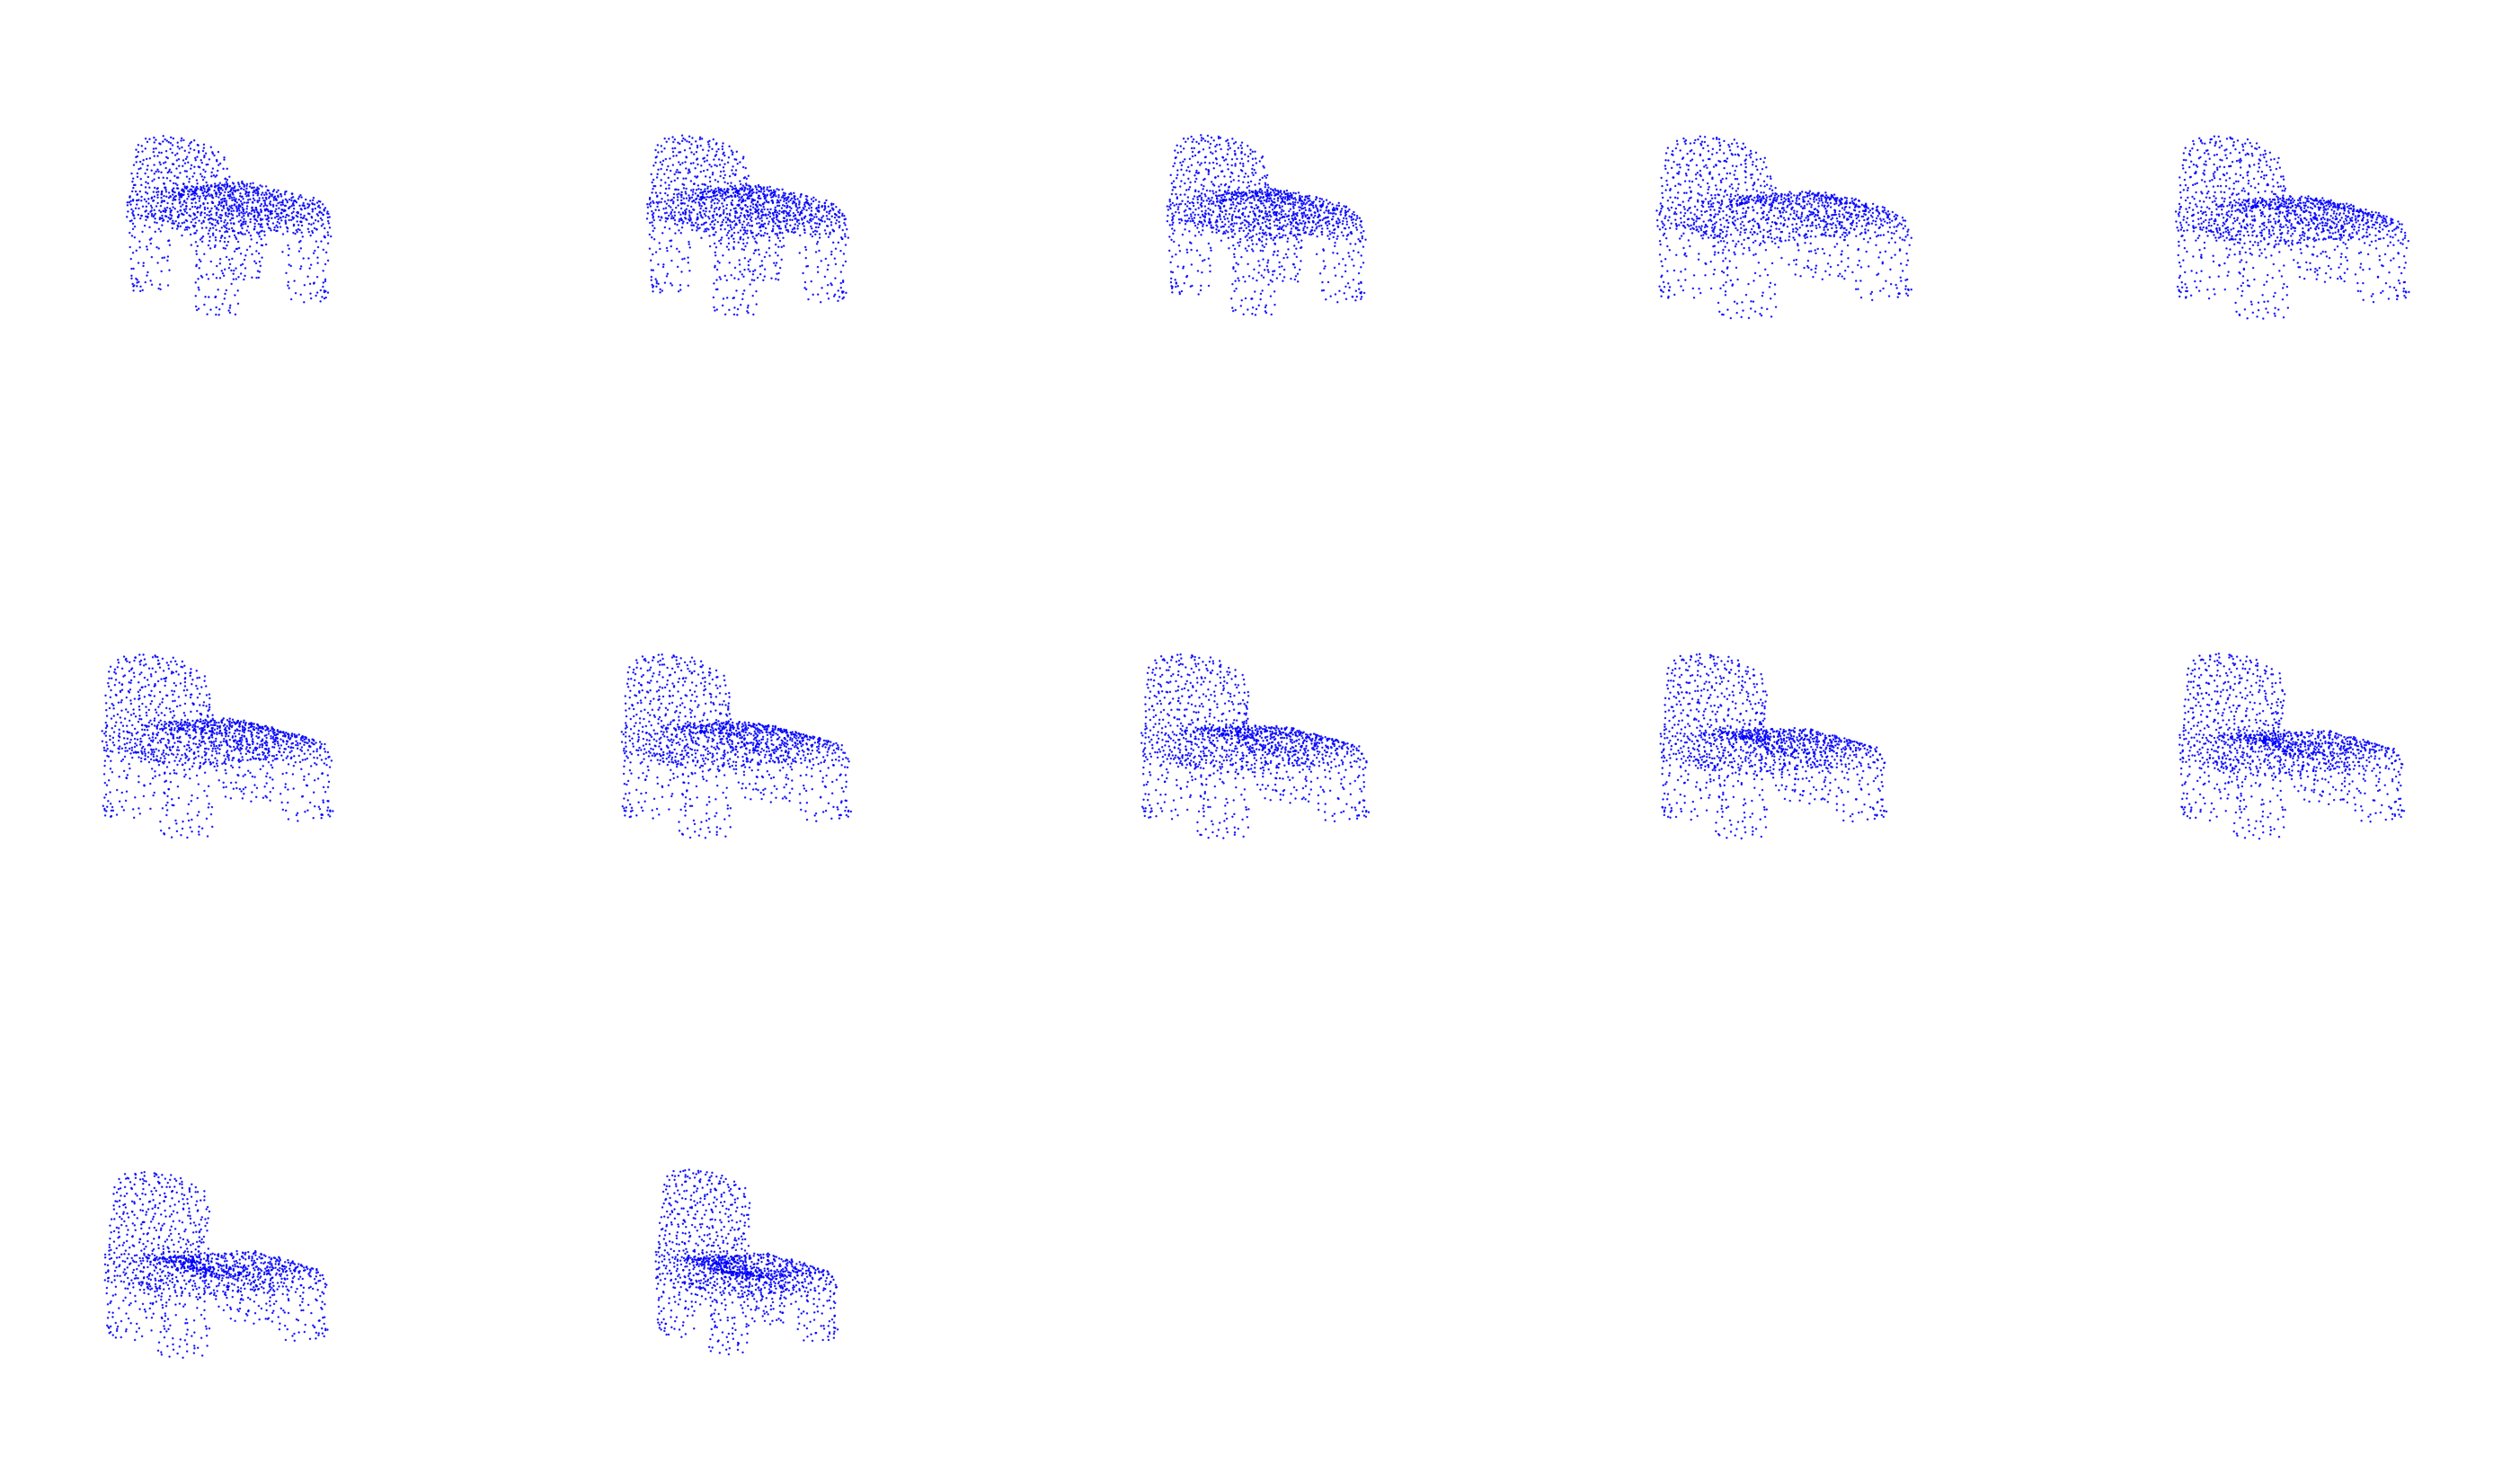

In [203]:
# ae.interpolate(latent_codes[0], latent_codes[1], 10)
# latent_codes[0].shape
inter_pc = ae.interpolate(full_pclouds[0], full_pclouds[1], 10)
from tf_lab.autopredictors.plotting import plot_interpolations

plot_interpolations(inter_pc, (, 5))